## Transfer learning
* ### Trainig a model
* ### Saving it and restoring
* ### Cloning the restored model to a new model
* ### Freeing all but top layer and fine tuning it
* ### Unfreezeing the whole network and fine tuing it on a reduced LR

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
tf.config.list_physical_devices('GPU')

In [2]:
fashion_mnist=tf.keras.datasets.fashion_mnist.load_data()

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

In [4]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [5]:
X_train.shape

(55000, 28, 28)

In [6]:
X_train.dtype

dtype('uint8')

In [7]:
# Data normalization
X_train, X_valid, X_test = X_train/255., X_valid/255., X_test/255. 

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [9]:
tf.random.set_seed(42)

## Model definition

In [ ]:
model = K.Sequential()

In [12]:
model

In [13]:
model.add(K.layers.Input(shape=[28, 28]))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(300, activation='relu'))
model.add(K.layers.Dense(100, activation='relu'))
model.add(K.layers.Dense(10, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss=K.losses.sparse_categorical_crossentropy,
             optimizer=K.optimizers.SGD(),
             metrics=[K.metrics.sparse_categorical_accuracy])

## Training

In [16]:
history = model.fit(X_train, y_train, 
         epochs=30,
         validation_data=[X_valid, y_valid])

Epoch 1/30
 174/1719 [==>...........................] - ETA: 1s - loss: 1.4653 - sparse_categorical_accuracy: 0.5643

2023-06-28 21:14:43.643183: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 2s 996us/step - loss: 0.7261 - sparse_categorical_accuracy: 0.7591 - val_loss: 0.5122 - val_sparse_categorical_accuracy: 0.8224
Epoch 2/30
1719/1719 [==============================] - 2s 999us/step - loss: 0.4909 - sparse_categorical_accuracy: 0.8288 - val_loss: 0.4658 - val_sparse_categorical_accuracy: 0.8308
Epoch 3/30
1719/1719 [==============================] - 2s 959us/step - loss: 0.4445 - sparse_categorical_accuracy: 0.8423 - val_loss: 0.4282 - val_sparse_categorical_accuracy: 0.8490
Epoch 4/30
1719/1719 [==============================] - 2s 935us/step - loss: 0.4196 - sparse_categorical_accuracy: 0.8534 - val_loss: 0.4004 - val_sparse_categorical_accuracy: 0.8578
Epoch 5/30
1719/1719 [==============================] - 2s 996us/step - loss: 0.3986 - sparse_categorical_accuracy: 0.8599 - val_loss: 0.3981 - val_sparse_categorical_accuracy: 0.8604
Epoch 6/30
1719/1719 [==============================] - 2s 985us/step - loss: 0.3819 - spar

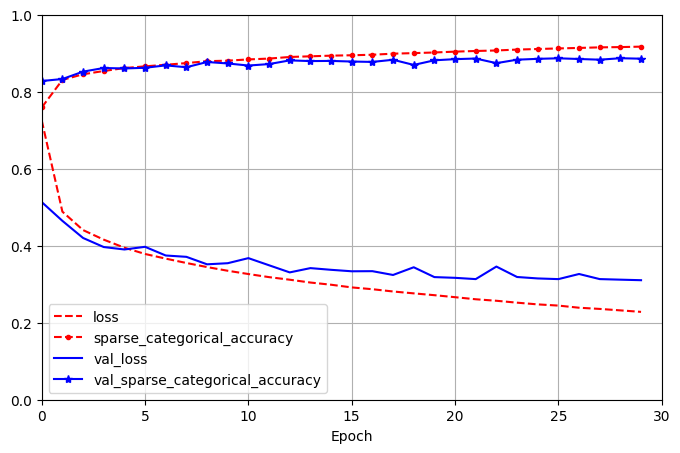

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5),
                                  xlim=[0, history.params['epochs']],
                                  ylim=[0, 1],
                                  grid=True,
                                  xlabel='Epoch',
                                  style=["r--", "r--.", "b-", "b-*"])
plt.show()

## Transfer learning

## Saving the trained model

In [17]:
model.save('my_model_A', save_format='tf')

INFO:tensorflow:Assets written to: my_model_A/assets


## Restoring the model

In [26]:
model_A = tf.keras.models.load_model("my_model_A")

## Copying the model 
## In this case training model B will affect model A

In [27]:
model_B_on_A = tf.keras.models.Sequential(model_A.layers[:-1])

In [28]:
model_B_on_A.add(tf.keras.layers.Dense(1, name='yolo', activation="sigmoid"))

## To avoid overwriting model A one needs to clone it and then build B on it

In [21]:
# This copies the architecture:
model_A_clone = tf.keras.models.clone_model(model_A)

# And this sets weight to the trained once
model_A_clone.set_weights(model_A.get_weights())

## Freezing layers up to the last one to train just the top new layer

In [29]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable=False

## Listing trainable layers

In [30]:
[layer.trainable for layer in model_B_on_A.layers]

[False, False, False, True]

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

## Freezing or unfreezing model requires recompile

In [31]:
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=optimizer,
                    metrics=['accuracy'])

## Preparing artificial data for fine tuning example

In [32]:
data_idx = (y_train == 9) | (y_train == 8)

In [33]:
valdata_idx = (y_valid == 9) | (y_valid == 8) 

In [34]:
reduced_X = X_train[data_idx]
reduced_y = y_train[data_idx]

In [35]:
reduced_y[reduced_y == 8] = 0
reduced_y[reduced_y == 9] = 1

In [36]:
reduced_valid_X = X_valid[valdata_idx]
reduced_valid_y = y_valid[valdata_idx]

In [37]:
reduced_valid_y[reduced_valid_y == 8] = 0
reduced_valid_y[reduced_valid_y == 9] = 1

In [38]:
reduced_valid_y.size

1037

## Fine tuning the new model

In [38]:
history = model_B_on_A.fit(reduced_X, reduced_y, epochs=4,
                          validation_data=(reduced_valid_X, reduced_valid_y))

Epoch 1/4
343/343 [==============================] - 1s 1ms/step - loss: 0.2184 - accuracy: 0.9597 - val_loss: 0.1113 - val_accuracy: 0.9942
Epoch 2/4
343/343 [==============================] - 0s 1ms/step - loss: 0.0878 - accuracy: 0.9965 - val_loss: 0.0674 - val_accuracy: 0.9961
Epoch 3/4
343/343 [==============================] - 0s 1ms/step - loss: 0.0592 - accuracy: 0.9974 - val_loss: 0.0504 - val_accuracy: 0.9961
Epoch 4/4
343/343 [==============================] - 0s 1ms/step - loss: 0.0460 - accuracy: 0.9975 - val_loss: 0.0412 - val_accuracy: 0.9961


## Unfreezing the reused layers

In [39]:
for layer in model_B_on_A.layers:
    layer.trainable=True

## Reducing the lr to protect reused layers

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

## Recompiling the model

In [40]:
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=optimizer,
                    metrics=['accuracy'])

In [41]:
history = model_B_on_A.fit(reduced_X, reduced_y, epochs=4,
                          validation_data=(reduced_valid_X, reduced_valid_y))

Epoch 1/4
343/343 [==============================] - 1s 1ms/step - loss: 0.0333 - accuracy: 0.9977 - val_loss: 0.0281 - val_accuracy: 0.9961
Epoch 2/4
343/343 [==============================] - 0s 1ms/step - loss: 0.0237 - accuracy: 0.9981 - val_loss: 0.0223 - val_accuracy: 0.9961
Epoch 3/4
343/343 [==============================] - 0s 1ms/step - loss: 0.0189 - accuracy: 0.9981 - val_loss: 0.0191 - val_accuracy: 0.9961
Epoch 4/4
343/343 [==============================] - 0s 1ms/step - loss: 0.0160 - accuracy: 0.9984 - val_loss: 0.0169 - val_accuracy: 0.9961
